In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import init_notebook_mode
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster,cophenet
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist


# Load the dataset
df = pd.read_csv('retail_customer_data.csv')

In [2]:
df.shape

(3000, 10)

In [3]:
df.head()

,customer_id,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
0,CUST_0001,1.8,3.0,527.04,38.1,0.95,17.3,0.00,23,33
1,CUST_0002,5.4,4.5,1137.72,20.0,0.00,16.1,0.41,1,8
2,CUST_0003,2.9,4.4,670.28,64.3,0.52,36.9,0.11,32,39
3,CUST_0004,12.0,22.8,6359.35,37.9,0.17,42.2,0.00,21,5
4,CUST_0005,2.2,17.6,4058.48,22.5,0.53,18.4,0.15,20,18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              3000 non-null   object 
 1   monthly_transactions     3000 non-null   float64
 2   avg_basket_size          3000 non-null   float64
 3   total_spend              3000 non-null   float64
 4   avg_session_duration     3000 non-null   float64
 5   email_open_rate          3000 non-null   float64
 6   product_views_per_visit  3000 non-null   float64
 7   return_rate              3000 non-null   float64
 8   customer_tenure_months   3000 non-null   int64  
 9   recency_days             3000 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 234.5+ KB


In [5]:
df.describe()

,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,6.011300,9.485133,2367.375387,38.441533,0.443720,31.359467,0.185890,17.912667,20.680667
std,4.776564,7.961280,2248.271454,14.334159,0.427384,9.964088,0.162283,11.242294,12.055419
min,0.200000,1.000000,50.000000,3.400000,0.000000,3.000000,0.000000,1.000000,1.000000
25%,2.100000,3.300000,511.115000,27.000000,0.000000,24.900000,0.040000,9.000000,11.000000
50%,5.000000,5.600000,1456.105000,36.550000,0.340000,31.600000,0.150000,18.000000,18.000000
75%,8.800000,17.325000,3772.227500,49.400000,0.950000,37.800000,0.290000,26.000000,29.250000
max,22.300000,31.600000,8746.290000,87.300000,0.950000,62.400000,0.500000,59.000000,67.000000


In [6]:
missing_summary = df.isnull().sum()
missing_summary

customer_id                0
monthly_transactions       0
avg_basket_size            0
total_spend                0
avg_session_duration       0
email_open_rate            0
product_views_per_visit    0
return_rate                0
customer_tenure_months     0
recency_days               0
dtype: int64

Dataset Size: 3,000 customers with 10 variables
Variables Available:
  - `customer_id`
  - `monthly_transactions`
  - `avg_basket_size`
  - `total_spend`
  - `avg_session_duration`
  - `email_open_rate`
  - `product_views_per_visit`
  - `return_rate`
  - `customer_tenure_months`
  - `recency_days`

Data Quality: 
No missing values detected in any column and all 3,000 records are complete

Data Types: 
  - 7 numerical (float64) behavioral variables
  - 2 numerical (int64) variables
  - 1 categorical (object) identifier

## EDA

In [7]:
#histograms for all behavioral variables (excluding customer_id)
behavioral_vars = df.columns.drop('customer_id')

fig = sp.make_subplots(
    rows=3, cols=3,
    subplot_titles=behavioral_vars,
    vertical_spacing=0.08,
    horizontal_spacing=0.05
)

for i, column in enumerate(behavioral_vars):
    row = i // 3 + 1
    col = i % 3 + 1
    
    fig.add_trace(
        go.Histogram(
            x=df[column], 
            name=column, 
            nbinsx=30,
            marker_color='skyblue',
            opacity=0.7
        ),
        row=row, col=col
    )

fig.update_layout(
    height=900,
    title_text="<b>Distribution of Behavioral Variables</b>",
    title_x=0.5,
    showlegend=False,
    template="plotly_white"
)

for i in range(1, 10):
    fig.update_xaxes(title_text="Value", row=(i-1)//3 + 1, col=(i-1)%3 + 1)
    fig.update_yaxes(title_text="Frequency", row=(i-1)//3 + 1, col=(i-1)%3 + 1)

fig.show()

In [8]:
#correlation matrix (excluding customer_id)
corr_matrix = df[behavioral_vars].corr()

fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='RdBu_r',
    zmin=-1,
    zmax=1,
    hoverongaps=False,
    text=corr_matrix.round(3),
    texttemplate="%{text}",
    textfont={"size": 10}
))

fig.update_layout(
    title="<b>Correlation Matrix Heatmap - Customer Behavioral Variables</b>",
    width=800,
    height=800,
    xaxis_title="Variables",
    yaxis_title="Variables",
    template="plotly_white"
)
fig.show()

In [9]:
#print highly correlated pairs
print("Highly Correlated Variable Pairs (|r| > 0.5):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.5:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))

for var1, var2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
    print(f"{var1} vs {var2}:{corr:.3f}")

Highly Correlated Variable Pairs (|r| > 0.5):
avg_basket_size vs total_spend:0.941
monthly_transactions vs total_spend:0.764
monthly_transactions vs avg_basket_size:0.691
monthly_transactions vs recency_days:-0.632
total_spend vs recency_days:-0.612
monthly_transactions vs product_views_per_visit:0.601


In [10]:
#box plots for key variables to detect outliers
key_Variables = ['total_spend', 'monthly_transactions', 'avg_basket_size', 'recency_days']

fig = go.Figure()
for var in key_Variables:
    fig.add_trace(go.Box(
        y=df[var], 
        name=var,
        boxpoints='suspectedoutliers',
        marker_color='lightseagreen',
        line_color='darkblue'
    ))

fig.update_layout(
    title="<b>Outlier Detection - Box Plots for Key Variables</b>",
    yaxis_title="Values",
    template="plotly_white",
    height=500,
    showlegend=False
)
fig.show()

In [11]:
#quantitative outlier analysis using IQR method
print("Outlier Analysis (IQR Method):")
for var in key_Variables:
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
    print(f"{var}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")

Outlier Analysis (IQR Method):
total_spend: 2 outliers (0.1%)
monthly_transactions: 18 outliers (0.6%)
avg_basket_size: 0 outliers (0.0%)
recency_days: 3 outliers (0.1%)


In [12]:
#total Spend vs Monthly Transactions
fig1 = px.scatter(
    df, 
    x='monthly_transactions', 
    y='total_spend',
    color='avg_basket_size',
    size='customer_tenure_months',
    hover_data=['recency_days', 'email_open_rate'],
    title="<b>Total Spend vs Monthly Transactions</b><br>Color: Avg Basket Size, Size: Customer Tenure",
    labels={
        'monthly_transactions': 'Monthly Transactions',
        'total_spend': 'Total Spend ($)',
        'avg_basket_size': 'Avg Basket Size'
    },
    color_continuous_scale='viridis'
)

fig1.update_layout(template="plotly_white")
fig1.show()

In [13]:
#recency vs Frequency behavior
fig2 = px.scatter(
    df, 
    x='recency_days', 
    y='monthly_transactions',
    color='total_spend',
    size='avg_basket_size',
    hover_data=['email_open_rate', 'return_rate'],
    title="<b>Recency vs Monthly Transactions</b><br>Color: Total Spend, Size: Avg Basket Size",
    labels={
        'recency_days': 'Recency (Days since last purchase)',
        'monthly_transactions': 'Monthly Transactions',
        'total_spend': 'Total Spend ($)'
    },
    color_continuous_scale='plasma'
)

fig2.update_layout(template="plotly_white")
fig2.show()

In [14]:
#engagement metrics
fig3 = px.scatter(
    df, 
    x='email_open_rate', 
    y='product_views_per_visit',
    color='avg_session_duration',
    size='total_spend',
    hover_data=['return_rate', 'customer_tenure_months'],
    title="<b>Email Engagement vs Product Views</b><br>Color: Session Duration, Size: Total Spend",
    labels={
        'email_open_rate': 'Email Open Rate',
        'product_views_per_visit': 'Product Views per Visit',
        'avg_session_duration': 'Avg Session Duration (min)'
    },
    color_continuous_scale='rainbow'
)
fig3.update_layout(template="plotly_white")
fig3.show()

## Data Preprocessing

In [15]:
missing_summary

customer_id                0
monthly_transactions       0
avg_basket_size            0
total_spend                0
avg_session_duration       0
email_open_rate            0
product_views_per_visit    0
return_rate                0
customer_tenure_months     0
recency_days               0
dtype: int64

In [16]:
#prepare data for clustering (exclude customer_id)
z = df[behavioral_vars].copy()

print("Original Data Statistics:")
z.head()

Original Data Statistics:


,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
0,1.8,3.0,527.04,38.1,0.95,17.3,0.00,23,33
1,5.4,4.5,1137.72,20.0,0.00,16.1,0.41,1,8
2,2.9,4.4,670.28,64.3,0.52,36.9,0.11,32,39
3,12.0,22.8,6359.35,37.9,0.17,42.2,0.00,21,5
4,2.2,17.6,4058.48,22.5,0.53,18.4,0.15,20,18


In [17]:
print("Original Data Ranges (Min-Max):")
original_ranges = pd.DataFrame({
    'Variable': z.columns,
    'Min': z.min().values,
    'Max': z.max().values,
    'Range': (z.max() - z.min()).values,
    'Std': z.std().values
})
original_ranges.round(2)

Original Data Ranges (Min-Max):


,Variable,Min,Max,Range,Std
0,monthly_transactions,0.2,22.30,22.10,4.78
1,avg_basket_size,1.0,31.60,30.60,7.96
2,total_spend,50.0,8746.29,8696.29,2248.27
3,avg_session_duration,3.4,87.30,83.90,14.33
4,email_open_rate,0.0,0.95,0.95,0.43
5,product_views_per_visit,3.0,62.40,59.40,9.96
6,return_rate,0.0,0.50,0.50,0.16
7,customer_tenure_months,1.0,59.00,58.00,11.24
8,recency_days,1.0,67.00,66.00,12.06


In [18]:
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)

X_scaled_df = pd.DataFrame(z_scaled, columns=z.columns, index=z.index)

print("Standardized Data Statistics:")
X_scaled_df.head().round(3)

Standardized Data Statistics:


,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
0,-0.882,-0.815,-0.819,-0.024,1.185,-1.411,-1.146,0.453,1.022
1,-0.128,-0.626,-0.547,-1.287,-1.038,-1.532,1.381,-1.505,-1.052
2,-0.651,-0.639,-0.755,1.804,0.179,0.556,-0.468,1.253,1.520
3,1.254,1.673,1.776,-0.038,-0.641,1.088,-1.146,0.275,-1.301
4,-0.798,1.019,0.752,-1.112,0.202,-1.301,-0.221,0.186,-0.222


In [19]:
print("Standardized Data Ranges (Min-Max):")
scaled_ranges = pd.DataFrame({
    'Variable': X_scaled_df.columns,
    'Min': X_scaled_df.min().values,
    'Max': X_scaled_df.max().values,
    'Mean': X_scaled_df.mean().values,
    'Std': X_scaled_df.std().values
})
scaled_ranges.round(3)

Standardized Data Ranges (Min-Max):


,Variable,Min,Max,Mean,Std
0,monthly_transactions,-1.217,3.411,0.0,1.0
1,avg_basket_size,-1.066,2.778,-0.0,1.0
2,total_spend,-1.031,2.838,0.0,1.0
3,avg_session_duration,-2.445,3.409,0.0,1.0
4,email_open_rate,-1.038,1.185,-0.0,1.0
5,product_views_per_visit,-2.847,3.116,0.0,1.0
6,return_rate,-1.146,1.936,-0.0,1.0
7,customer_tenure_months,-1.505,3.655,0.0,1.0
8,recency_days,-1.633,3.843,-0.0,1.0


## Why Standardization is Necessary for Clustering

### The Problem:
Without standardization, variables with larger numerical ranges (like `total_spend` ranging from $50 to $8,746) would dominate the distance calculations in clustering algorithms, while variables with smaller ranges (like `email_open_rate` ranging from 0 to 0.95) would have minimal impact.

### Impact on Our Data:
- **Before**: Variables had vastly different scales and units
- **After**: All variables are on comparable scales, ensuring equal importance in distance calculations

### Why This Matters for Clustering:
1. **Distance-based algorithms** (K-Means, Hierarchical) rely on Euclidean distance
2. **Equal contribution** from all variables in cluster formation
3. **Better cluster quality** and more meaningful customer segments

## Hierarchical Clustering Analysis

In [20]:
#compute linkage matrices for all four methods (deepseek intervention)
linkage_methods = ['single', 'complete', 'average', 'ward']
linkage_matrices = {}

for method in linkage_methods:
    linkage_matrices[method] = linkage(X_scaled_df, method=method)
    print(f"{method.capitalize()} linkage computed, Shape: {linkage_matrices[method].shape}")

linkage_matrices['ward'][:5].round(3)

Single linkage computed, Shape: (2999, 4)
Complete linkage computed, Shape: (2999, 4)
Average linkage computed, Shape: (2999, 4)
Ward linkage computed, Shape: (2999, 4)


array([[6.260e+02, 2.619e+03, 1.130e-01, 2.000e+00],
       [1.010e+02, 1.033e+03, 1.170e-01, 2.000e+00],
       [1.440e+02, 2.059e+03, 1.560e-01, 2.000e+00],
       [9.780e+02, 2.767e+03, 1.630e-01, 2.000e+00],
       [1.367e+03, 2.567e+03, 1.750e-01, 2.000e+00]])

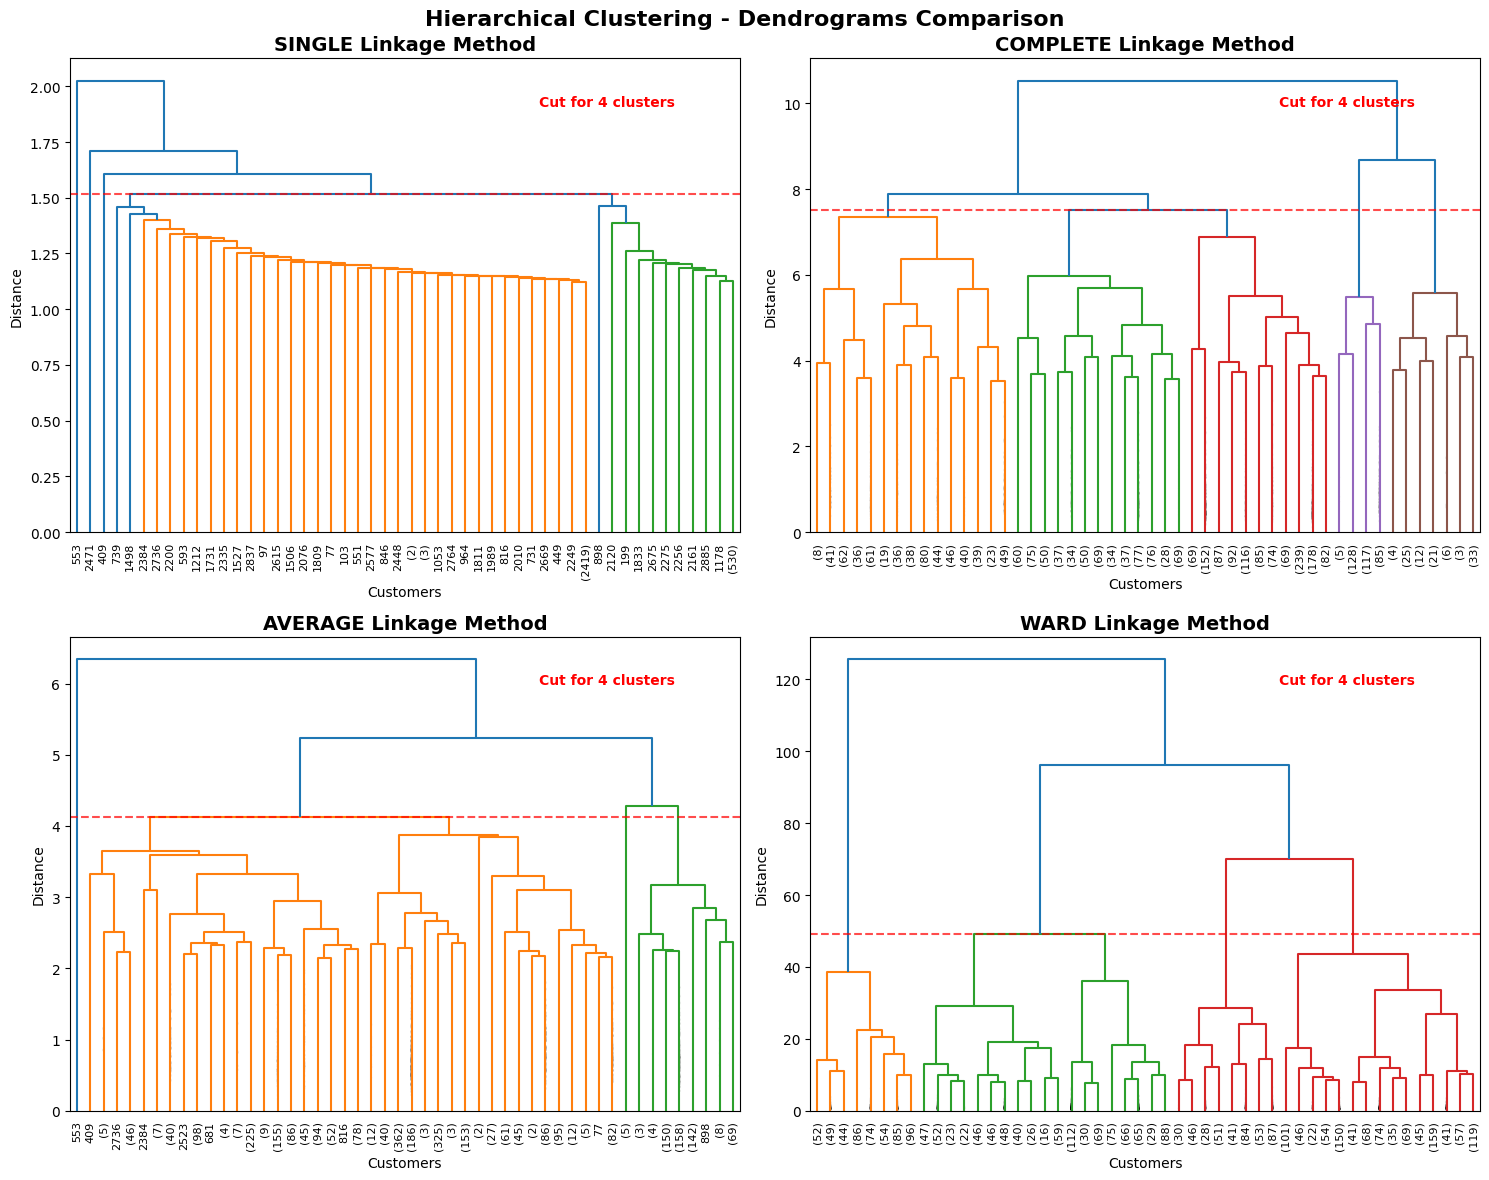

In [21]:
# Create dendrograms for all four linkage methods (deepseek intervention)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, method in enumerate(linkage_methods):
    # Create dendrogram
    dendrogram(
        linkage_matrices[method],
        ax=axes[i],
        truncate_mode='lastp',
        p=50,  # Show last 50 merges for clarity
        show_leaf_counts=True,
        leaf_rotation=90,
        leaf_font_size=8,
        show_contracted=True
    )
    axes[i].set_title(f'{method.upper()} Linkage Method', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Customers')
    axes[i].set_ylabel('Distance')
    
    # Add horizontal line at potential cut point
    cut_distance = linkage_matrices[method][-4, 2]  # Cut for 4 clusters
    axes[i].axhline(y=cut_distance, color='r', linestyle='--', alpha=0.7)
    axes[i].text(0.7, 0.9, f'Cut for 4 clusters', 
                transform=axes[i].transAxes, color='red', fontweight='bold')

plt.suptitle('Hierarchical Clustering - Dendrograms Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Interpretation of Dendrograms

Comparative Analysis of Linkage Methods


Single Linkage


This method tends to produce elongated, chain-like clusters due to the chaining effect, where points are merged one by one as long as there is a short distance between them. This often leads to poorly separated and less meaningful clusters, making it less suitable for customer segmentation.


Complete Linkage


Focuses on the maximum distance between points of different clusters, produces more compact and well-separated clusters compared to the Single Linkage method.


Average Linkage


Represents a balance between the Single and Complete methods, uses the average distance between all pairs of points in two clusters, resulting in balanced groupings that are less sensitive to outliers.


Ward Linkage


Minimizes the variance within clusters at each merge. Tends to create compact, spherical, and well-separated clusters, which makes it ideal for customer segmentation and market analysis.
In this case, the Ward method appears to be the most suitable, as it clearly defines four distinct and stable clusters.


Choosing the Cut in the Dendrogram

The cut point is selected where there is a large increase in distance between consecutive merges, this jump indicates that clusters being merged beyond that height are no longer similar, so cutting before it ensures high internal cohesion within each cluster, in the plots, the red dashed line shows the level where **4 clusters** are formed, with Ward’s method showing the cleanest separation.


The Chaining Effect

Occurs when clusters form long chains of sequentially linked points that do not represent true similarity, this effect is **most pronounced in the Single Linkage method**, which makes it less effective for clearly separated groups.